In [1]:
# Importing required libraries for data manipulation, model training, and evaluation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split

# Ensure reproducibility
np.random.seed(50)
tf.random.set_seed(50)

In [2]:
# Load dataset and display basic information

# Define the path to the dataset
dataset_path = '../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")

# Display dataset information
df.info()

# Display the first five rows for a quick preview
df.head()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726984 entries, 0 to 726983
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         726984 non-null  object 
 1   device_id    726984 non-null  object 
 2   co2          726984 non-null  float64
 3   humidity     726984 non-null  float64
 4   pm25         726984 non-null  float64
 5   pressure     726984 non-null  float64
 6   temperature  726984 non-null  float64
 7   rssi         726984 non-null  float64
 8   snr          726984 non-null  float64
 9   SF           726984 non-null  int64  
 10  frequency    726984 non-null  float64
 11  f_count      726984 non-null  float64
 12  p_count      726984 non-null  float64
 13  toa          726984 non-null  float64
 14  distance     726984 non-null  int64  
 15  c_walls      726984 non-null  int64  
 16  w_walls      726984 non-null  int64  
 17  exp_pl       726984 non-null  float64


,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:00:52.542462+00:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 11:01:52.383162+00:00,ED3,645.0,54.18,0.32,300.48,23.87,-74.0,12.5,9,867.7,95.0,105.0,0.246784,18,1,2,91.4,-86.737602,-74.237602
2,2024-09-26 11:02:52.425491+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
3,2024-09-26 11:02:52.426016+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
4,2024-09-26 11:03:52.481201+00:00,ED3,645.0,54.25,0.33,300.50,23.90,-76.0,13.2,9,868.3,97.0,107.0,0.246784,18,1,2,93.4,-89.403045,-76.203045


In [3]:
# Extract necessary columns and perform train-test split with normalization

# Define feature columns and target
feature_columns = [
    'distance', 
    'frequency', 
    'c_walls', 
    'w_walls', 
    'co2', 
    'humidity', 
    'pm25', 
    'pressure', 
    'temperature', 
    'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist in the dataframe
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, 
    PL_all, 
    test_size=0.2, 
    random_state=50
)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_all_scaled = scaler.fit_transform(X_train_all)

# Transform the test data
X_test_all_scaled = scaler.transform(X_test_all)

print("Feature scaling completed.")

Feature scaling completed.


In [4]:
# Define the ANN model architecture and train it with EarlyStopping

def create_ann_model(input_dim):
    """Creates an ANN model for regression with regularization and input layer."""
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Explicit Input layer
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))  # Increased dropout rate
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='linear'))  # Output layer for regression

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Instantiate the model
input_dim = X_train_all_scaled.shape[1]
model = create_ann_model(input_dim)
model.summary()

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased patience
    restore_best_weights=True
)

# Train the model with EarlyStopping and adjusted parameters
history = model.fit(
    X_train_all_scaled,
    PL_train_all,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    verbose=1,
    callbacks=[early_stop]
)

print("Model training completed.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2878.9521 - mae: 41.3543 - val_loss: 92.5791 - val_mae: 6.3333
Epoch 2/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 389.4731 - mae: 14.7937 - val_loss: 60.9850 - val_mae: 5.3912
Epoch 3/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 270.0484 - mae: 12.6285 - val_loss: 102.5726 - val_mae: 7.4307
Epoch 4/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 183.4560 - mae: 10.3083 - val_loss: 116.4908 - val_mae: 8.2881
Epoch 5/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 128.0515 - mae: 8.4672 - val_loss: 88.2318 - val_mae: 7.0467
Epoch 6/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 80.7248 - mae: 6.5125 - val_loss: 114.6226 - val_mae: 8.3217
Epoch 7/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 62.7907 - mae: 5.7027 - val_loss: 122.5279 - val_mae: 8.5881
Epoch 8/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 56.4557 - mae: 5.4327 - val_loss: 123.3803 - val_mae: 8.7175
Epoch 9/5

In [5]:
# Evaluate the trained model on training and test data

# Evaluate the model on training data
train_loss, train_mae = model.evaluate(X_train_all_scaled, PL_train_all, verbose=0)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)

# Predict path loss for the test set
PL_pred = model.predict(X_test_all_scaled)

# Calculate additional metrics
rmse_test = np.sqrt(mean_squared_error(PL_test_all, PL_pred))
r2_test = r2_score(PL_test_all, PL_pred)
mape_test = mean_absolute_percentage_error(PL_test_all, PL_pred)
median_ae_test = median_absolute_error(PL_test_all, PL_pred)

# Display metrics
print(f"\nTraining Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R² Score: {r2_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%, Test Median Absolute Error: {median_ae_test:.4f}")

4544/4544 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step   

Training Loss (MSE): 60.9535, Training MAE: 5.3961
Test Loss (MSE): 57.3744, Test MAE: 5.3881
Test RMSE: 7.5698, R² Score: 0.8385
Test MAPE: 0.06%, Test Median Absolute Error: 3.9853


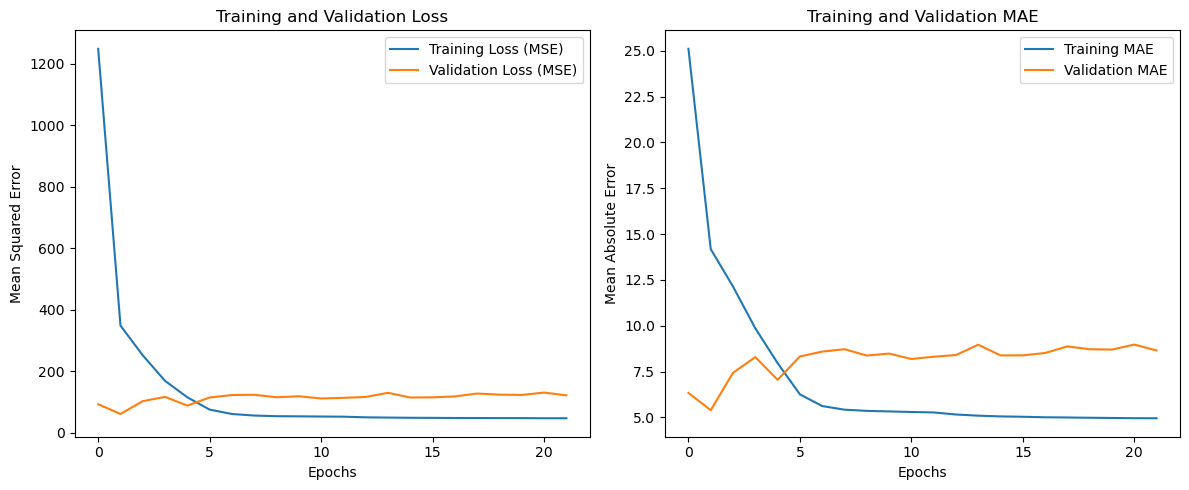

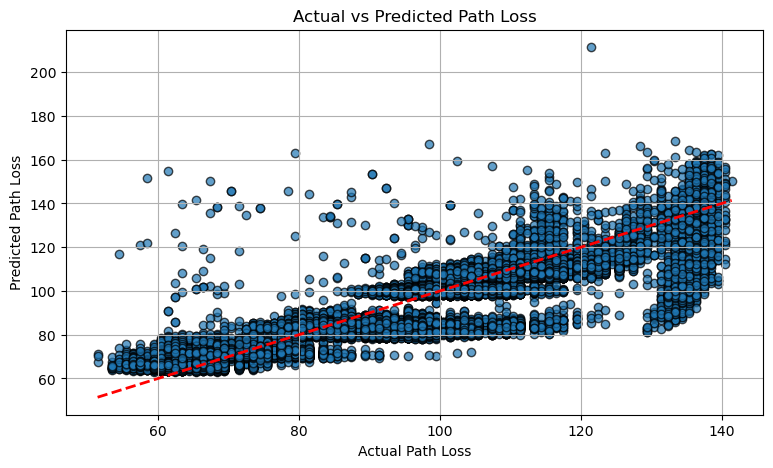

In [6]:
# Visualize training history and model predictions

# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(9, 5))
plt.scatter(PL_test_all, PL_pred, alpha=0.7, edgecolor='k')
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss')
plt.grid(True)
plt.show()

In [ ]:
# Perform K-Fold Cross-Validation to assess model robustness

# Define K-Fold Cross Validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
test_losses = []
test_maes = []

for train_index, val_index in kf.split(X_train_all_scaled):
    print(f"Training fold {fold}...")
    
    # Split data into training and validation for the current fold
    X_train_fold, X_val_fold = X_train_all_scaled[train_index], X_train_all_scaled[val_index]
    PL_train_fold, PL_val_fold = PL_train_all[train_index], PL_train_all[val_index]
    
    # Create a new instance of the model for each fold
    model = create_ann_model(input_dim)
    
    # Define EarlyStopping callback
    early_stop_cv = EarlyStopping(
        monitor='val_loss',
        patience=20,  # Patience can be adjusted as needed
        restore_best_weights=True
    )
    
    # Train the model on the current fold
    history_cv = model.fit(
        X_train_fold, 
        PL_train_fold, 
        validation_data=(X_val_fold, PL_val_fold),
        epochs=50, 
        batch_size=256, 
        callbacks=[early_stop_cv],
        verbose=1  
    )
    
    # Evaluate the model on the test set
    test_loss, test_mae = model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)
    test_losses.append(test_loss)
    test_maes.append(test_mae)
    
    print(f"Fold {fold} - Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}\n")
    fold += 1

# Calculate and display average metrics across all folds
average_test_loss = np.mean(test_losses)
average_test_mae = np.mean(test_maes)
print(f"Average Test Loss (MSE) across all folds: {average_test_loss:.4f}")
print(f"Average Test MAE across all folds: {average_test_mae:.4f}")

Training fold 1...
Epoch 1/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2439.4336 - mae: 37.4003 - val_loss: 122.7056 - val_mae: 8.0311
Epoch 2/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 337.2621 - mae: 14.0760 - val_loss: 288.2022 - val_mae: 14.7141
Epoch 3/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 194.9557 - mae: 10.4864 - val_loss: 419.4130 - val_mae: 18.7137
Epoch 4/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 141.8761 - mae: 8.7968 - val_loss: 423.7186 - val_mae: 19.1617
Epoch 5/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 97.8135 - mae: 7.2423 - val_loss: 350.6714 - val_mae: 17.1057
Epoch 6/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 68.4133 - mae: 5.9485 - val_loss: 256.5752 - val_mae: 14.1122
Epoch 7/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 53.6703 - mae: 5.1937 - val_loss: 221.1809 - val_mae: 12.7060
Epoch 8/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 47.8553 - mae: 4.9020 - val_loss: 211.7408 -